# Adding imports

In [62]:
import requests
import os
import json
import datetime
import subprocess
import logging as logger
import cv2
import numpy as np

from os.path import join, dirname
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from moviepy.editor import *
from keras.models import model_from_json

## Loading environment and local variables

In [39]:
dotenv_path = join(dirname(os.path.abspath('')), '.env')
load_dotenv(dotenv_path)
os.chdir('/app')

logger.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

def dump_json(data, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)


def get_twitch_token():
    payload = {
        'client_id' : os.environ.get("CLIENT_ID"),
        'client_secret': os.environ.get("CLIENT_SECRET"),
        'grant_type': 'client_credentials'
    }
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    response = requests.post("https://id.twitch.tv/oauth2/token", headers=headers, data=payload)

    return json.loads(response.text)["access_token"]


token = get_twitch_token()
headers = {'Authorization': f'Bearer {token}', 'Client-Id': os.environ.get("CLIENT_ID")}

In [8]:
def get_streamers():
    '''
    Retreive from a third party website the list of the most watched streamers
    Returns a list of strings
    '''
    results = []
    request = requests.get('https://www.twitchmetrics.net/channels/viewership?game=League+of+Legends&lang=en&page=1')
    parsed_html = BeautifulSoup(request.text)

    for name in parsed_html.body.find_all('h5', attrs={'class':'mr-2 mb-0'}):
        results.append(name.get_text())
    
    return results



In [9]:
def convert_name_to_id(name):
    '''
        Converts the basic name (e.g. Thebausffs) to the broadcaster id, which twitch uses to identify the streamer
        There are some exceptions with names, that involve whitespaces between them: only staff members can use them, and when putting
        the name in the endpoint will result in a error, so the name has to be stripped of it
    '''
    params = { "login" : "".join(name.split()) }
    request = requests.get(f'https://api.twitch.tv/helix/users', headers=headers, params=params)
    if request.ok:
        return json.loads(request.text)["data"][0]["id"]
    else:
        raise Exception(f'Error from twitch endpoint {request.text}')



In [10]:
def clips_from_broadcaster_id(id):
    '''Retreives the clips from a streamer, based also on timeframe, and sorted by views'''
    format_time = "%Y-%m-%dT%H:%M:%SZ"
    params = {
        "broadcaster_id" : id,
        "started_at" : (datetime.datetime.now() - datetime.timedelta(days=3)).strftime(format_time),
        "ended_at" : datetime.datetime.now().strftime(format_time)
    }
    request = requests.get(f'https://api.twitch.tv/helix/clips', headers=headers, params=params)
    return json.loads(request.text)["data"]



In [11]:
def download_clip(clip):
    path = join(dirname(os.path.abspath('')), f'files/clips/{clip["title"]}.mp4')
    index = clip["thumbnail_url"].find('-preview')
    clip_url = clip["thumbnail_url"][:index] + '.mp4'
    r = requests.get(clip_url)

    if r.headers['Content-Type'] == 'binary/octet-stream':
        if not os.path.exists('files/clips'): os.makedirs('files/clips')
        with open(path, 'wb') as f:
            f.write(r.content)
        return path
    else:
        print(f'Failed to download clip from thumb: {clip["thumbnail_url"]}')



In [12]:
def overlay_video(original_video, overlay_video):
    output_path="output.mp4"

    video_clip = VideoFileClip((original_video), target_resolution=(1080, 1920)) #b .mp4 file

    overlay_clip = VideoFileClip((overlay_video), has_mask=True, target_resolution=(1080, 1920)) #.mov file with alpha channel

    final_video = CompositeVideoClip([video_clip, overlay_clip])  


    final_video.write_videofile(
        output_path,
        threads = 6,
    )

In [13]:
def main():
    logger.info('Program started')
    logger.info('BRUH')

    time = 2 * 60
    video_time = 0

    clips = []

    streamers = get_streamers()

    for streamer in streamers:
        if streamer == "Riot Games":
            continue
        streamer_id = convert_name_to_id(streamer)
        clips_downloaded = clips_from_broadcaster_id(streamer_id)[:3]
        if video_time > time:
            break
        for clip in clips_downloaded:
            video_time += float(clip["duration"])
            clips.append(download_clip(clip))
    
    transition_time = 2
    video_clips = [VideoFileClip(clips.pop(0))]
    
    for clip in clips:
        video_clips.append(VideoFileClip(clip).crossfadein(transition_time))

    final = concatenate_videoclips(video_clips, padding=-transition_time, method="compose")
    final.write_videofile("files/clips/final_output.mp4")
    #Adding intro
    overlay_video("files/clips/final_output.mp4", "files/intro.mov")


In [14]:
main()

Moviepy - Building video files/clips/final_output.mp4.
MoviePy - Writing audio in final_outputTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video files/clips/final_output.mp4



t:  32%|███▏      | 3344/10446 [02:40<17:54,  6.61it/s, now=None]11/29/2023 08:51:29 PM /usr/local/lib/python3.9/site-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file files/clips/nein.mp4, 6220800 bytes wanted but 0 bytes read,at frame 964/965, at time 16.07/16.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready files/clips/final_output.mp4


OSError: MoviePy error: the file files/intro.mov could not be found!
Please check that you entered the correct path.

In [94]:
def read_video_emotion(video):

    results_percentage = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
    count = 0

    def extract_features(image):
        feature = np.array(image)
        feature = feature.reshape(1,48,48,1)
        return feature/255.0

    json_file = open("/app/files/models/emotion/emotiondetector.json", "r")
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    
    model.load_weights("/app/files/models/emotion/emotiondetector.h5")
    haar_file=cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_cascade=cv2.CascadeClassifier(haar_file)

    labels = {0 : 'angry', 1 : 'disgust', 2 : 'fear', 3 : 'happy', 4 : 'neutral', 5 : 'sad', 6 : 'surprise'}
    
    vidcap = cv2.VideoCapture(join(dirname(os.path.abspath('')),f'files/clips/{video}'))
    success,image = vidcap.read()
    while success:
        faces = face_cascade.detectMultiScale(image,1.3,5)
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        print(faces)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
        for (p,q,r,s) in faces:
            count += 1
            image = gray[q:q + s, p:p + r]
            image = cv2.resize(image,(48,48))
            img = extract_features(image)
            pred = model.predict(img)
            prediction_label = labels[pred.argmax()]
            results_percentage[prediction_label] += 1
            print(prediction_label)
        success,image = vidcap.read()
    
    return results_percentage

()


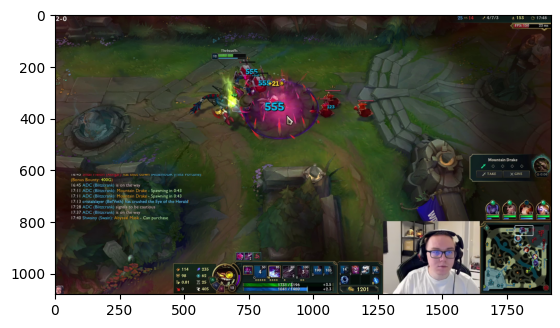

()


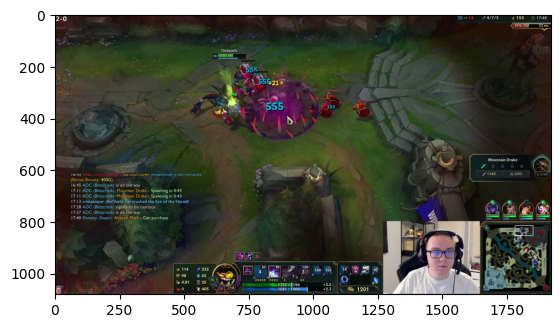

()


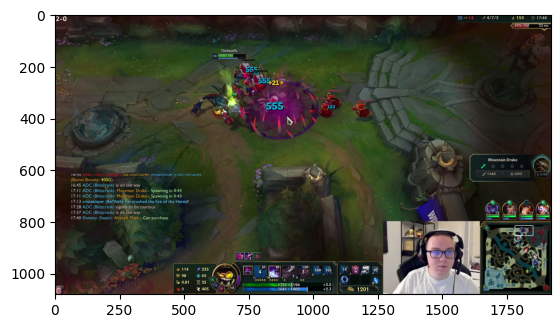

()


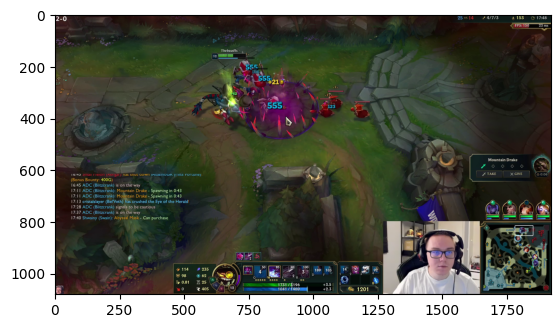

()


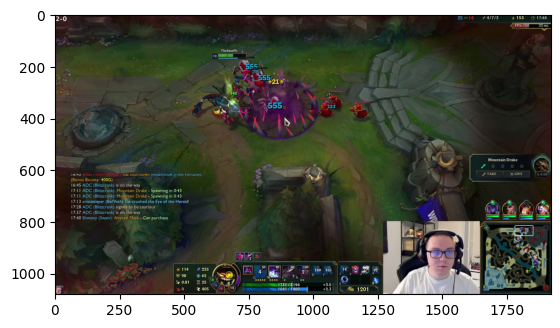

()


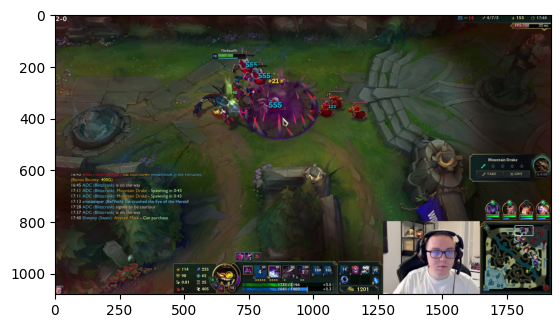

()


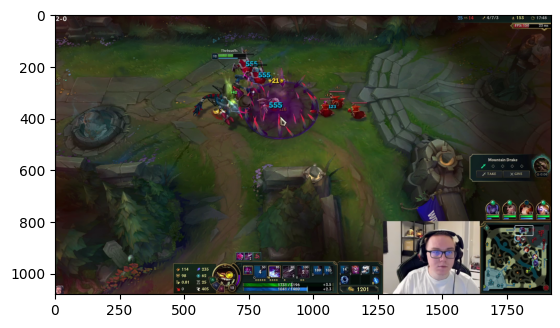

()


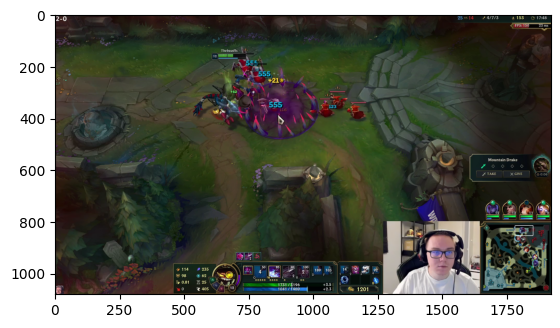

()


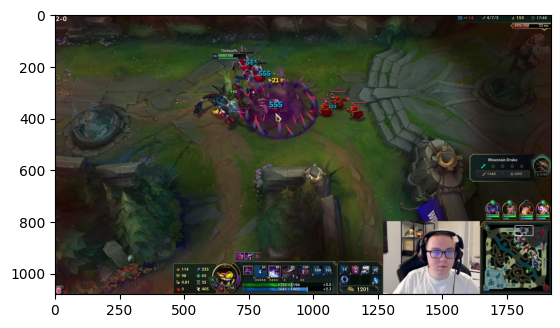

()


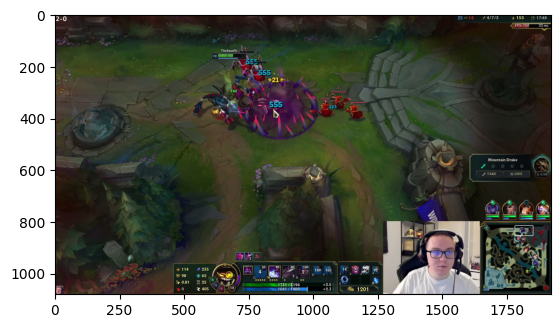

()


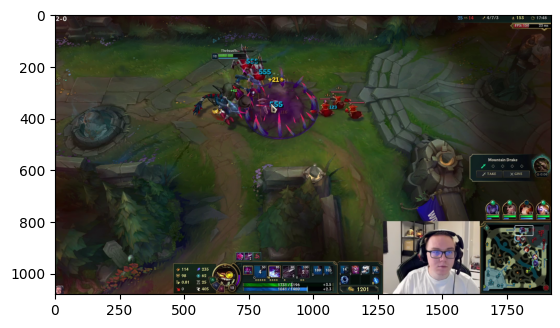

()


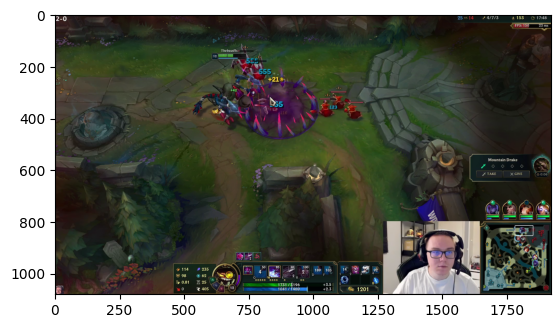

()


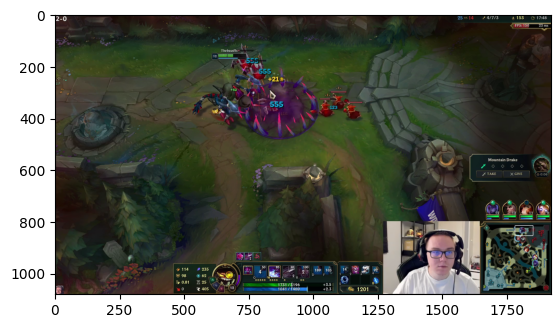

()


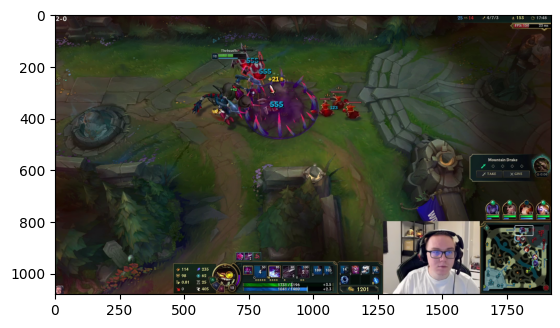

()


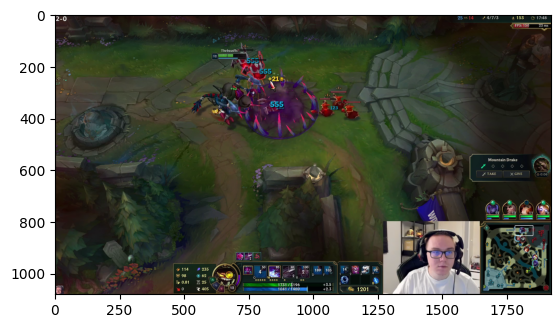

()


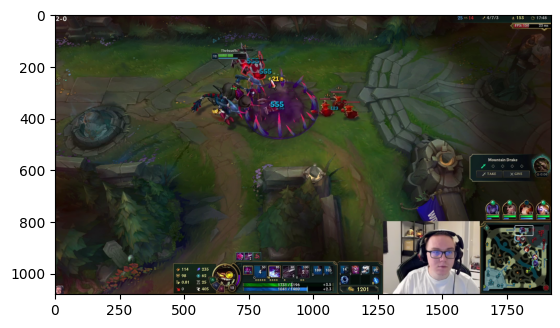

()


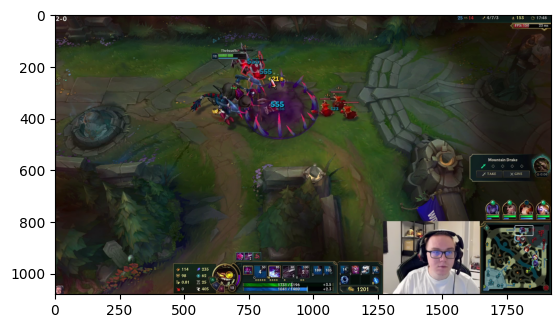

()


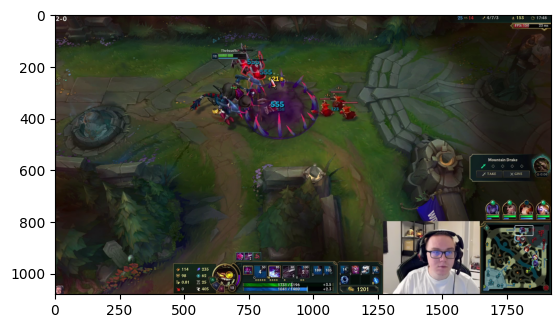

()


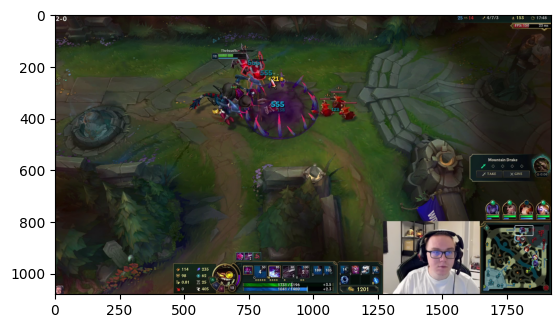

()


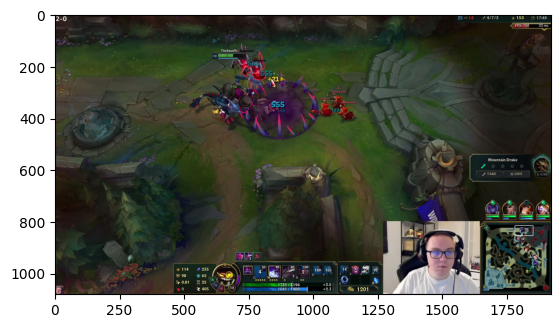

()


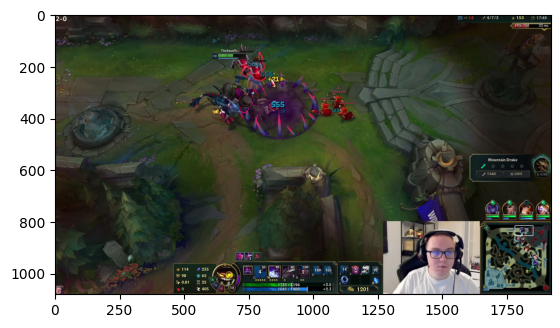

()


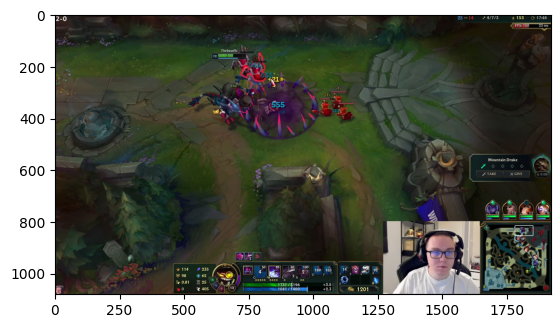

()


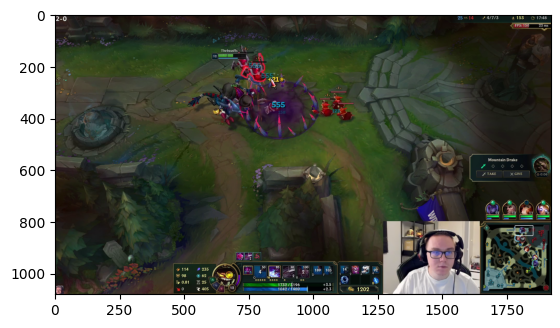

()


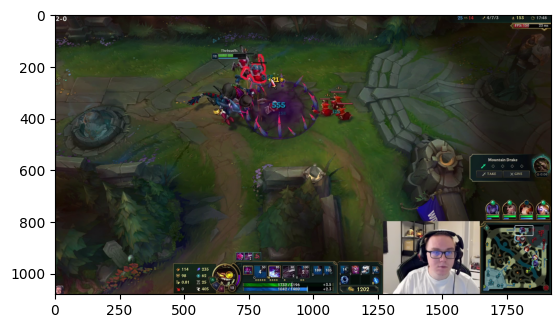

()


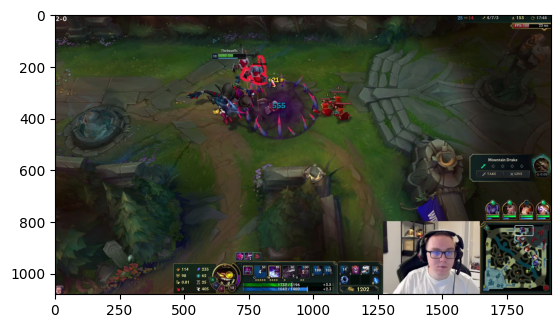

()


In [ ]:
%%time
results = read_video_emotion('b.mp4')

In [65]:
results

{'angry': 7,
 'disgust': 0,
 'fear': 0,
 'happy': 1,
 'neutral': 0,
 'sad': 1,
 'surprise': 3}

In [33]:
results_percentage = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
count = 0
video = "Ult hit.mp4"
def extract_features(image):
    feature = np.array(image)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

json_file = open("/app/files/models/emotion/emotiondetector.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

model.load_weights("/app/files/models/emotion/emotiondetector.h5")
haar_file=cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade=cv2.CascadeClassifier(haar_file)

labels = {0 : 'angry', 1 : 'disgust', 2 : 'fear', 3 : 'happy', 4 : 'neutral', 5 : 'sad', 6 : 'surprise'}

vidcap = cv2.VideoCapture(join(dirname(os.path.abspath('')),f'files/clips/{video}'))
success,image = vidcap.read()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(image,1.3,5)
while success:
    for (p,q,r,s) in faces:
        count += 1
        image = gray[q:q + s, p:p + r]
        image = cv2.resize(image,(48,48))
        img = extract_features(image)
        pred = model.predict(img)
        prediction_label = labels[pred.argmax()]
        results_percentage[prediction_label] += 1
    success,image = vidcap.read()

In [19]:
vidcap = cv2.VideoCapture(join(dirname(os.path.abspath('')),f'files/clips/{video}'))
success,image = vidcap.read()

In [24]:
import cv2
from matplotlib import pyplot as plt

#Import image
vidcap = cv2.imread(join(dirname(os.path.abspath('')),f'files/clips/{video}'))
success,image = vidcap.read()
#Show the image with matplotlib
plt.imshow(image)
plt.show()

AttributeError: 'NoneType' object has no attribute 'read'

In [28]:
join(dirname(os.path.abspath('')),f'files/clips/{video}')

'/app/files/clips/POG MF !1!11!!1!!111!.mp4'

In [31]:
vidcap = cv2.imread(join(dirname(os.path.abspath('')),f'files/clips/final_output.mp4'))
success,image = vidcap.read()
#Show the image with matplotlib
plt.imshow(image)
plt.show()

AttributeError: 'NoneType' object has no attribute 'read'